## Introduction

In this project we will create a Stacked Sparse Denoising Autoencoder (SSDA) with the purpose of denoising grayscale images.

This SSDA model is made up of two autoencoders. Rather than training the entire model at once, we will train the two autoencoder layers individually, save their weights, and then use those weights to initialize the stacked autoencoder model.

A single autoencoder model includes an input layer, an encoding layer and a decoding layer. After training the first autoencoder and saving its weights, we run the original clean and noisy patches through the input and encoding layers of our training model. The output patches of this model become the input patches to the second autoencoder’s training model.

We train the fully assembled SSDA model by initializing the two encoding layers to the weights saved from our individually trained autoencoder models. We provide the trained SSDA model with noisy test images and evaluate its performance.

### Imports

In [1]:
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
from keras.layers import Input, Dense

Using TensorFlow backend.


In [3]:
from keras.models import Model

In [4]:
import numpy as np

In [5]:
import os

In [6]:
import cv2

In [7]:
import matplotlib.pyplot as plt

### Paths to training, validating and testing data

For this assignment, we will use images from the Berkeley Segmentation Data Set and Benchmarks 500 (BSDS500). The BSDS500 dataset provides three categories of images: train, val, and test, which we will use for training, validating, and testing the models.
https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/resources.html

In [8]:
path_folder = ".\BSR"
path_train_img = os.path.join(path_folder, "train")
path_val_img = os.path.join(path_folder, "val")
path_test_img = os.path.join(path_folder, "test")

## Patches
To reduce the dimensionality of the data, we will convert the images to greyscale.

For each image in the train, validate, and test datasets, we will create clean and noisy patches using a window size of 8x8 and a step size of 8.

Each noisy patch is created by applying random gaussian noise to its equivalent clean patch. Set the seed variable to allow comparison between program executions.

### Method for Sliding window

In [9]:
def sliding_window(image, window_shape, step_size):
    rows = image.shape[0]
    cols = image.shape[1]
    for x in range(0, rows, step_size):
        for y in range(0, cols, step_size):
            yield(x, y, image[x:x+window_shape[0], y:y+window_shape[1]])
            

### Method for Creating patches

In [10]:
def create_clean_patches(path_images, window_shape, step_size):
    patches = []
    print ('Creating CLEAN ' + str(window_shape[0]) + '*' + str(window_shape[1]) + ' patches for images in ' + path_images)
    for i, filename in enumerate(os.listdir(path_images)):
        image = cv2.imread(path_images + os.path.sep + filename, cv2.IMREAD_GRAYSCALE)
        for (x, y, window) in sliding_window(image, window_shape, step_size):
            if(window.shape == window_shape):
                patches.append(window.flatten())
    print ('All Patched Created added to list')
    print()
    return np.array(patches)

In [11]:
#Citation: http://www.magikcode.com/?p=240
def add_gaussian_noise(image_in, noise_sigma):
    temp_image = np.float64(np.copy(image_in))

    h = temp_image.shape[0]
    w = temp_image.shape[1]
    np.random.seed(123456789)
    noise = np.random.randn(h, w) * noise_sigma

    noisy_image = np.zeros(temp_image.shape, np.float64)
    if len(temp_image.shape) == 2:
        noisy_image = temp_image + noise
    else:
        noisy_image[:,:,0] = temp_image[:,:,0] + noise
        noisy_image[:,:,1] = temp_image[:,:,1] + noise
        noisy_image[:,:,2] = temp_image[:,:,2] + noise

    return noisy_image

In [12]:
def create_noisy_patches(path_images, window_shape, step_size):
    patches = []
    print ('Creating NOISY ' + str(window_shape[0]) + '*' + str(window_shape[1]) + ' patches for images in ' + path_images)
    for i, filename in enumerate(os.listdir(path_images)):
        image = cv2.imread(path_images + os.path.sep + filename, cv2.IMREAD_GRAYSCALE)
        #add noise to image
        image = add_gaussian_noise(image, 25)
        for (x, y, window) in sliding_window(image, window_shape, step_size):
            if(window.shape == window_shape):
                patches.append(window.flatten())
    print ('All Patched Created added to list')
    print()
    return np.array(patches)

### Creating Patches

In [13]:
window_shape = (8,8)
step_size = 8

#### Clean Patches

In [14]:
clean_patches_train_8 = create_clean_patches(path_train_img, window_shape, step_size)

Creating CLEAN 8*8 patches for images in .\BSR\train
All Patched Created added to list



In [15]:
clean_patches_val_8 = create_clean_patches(path_val_img, window_shape, step_size)

Creating CLEAN 8*8 patches for images in .\BSR\val
All Patched Created added to list



In [16]:
clean_patches_test_8 = create_clean_patches(path_test_img, window_shape, step_size)

Creating CLEAN 8*8 patches for images in .\BSR\test
All Patched Created added to list



#### Noisy Patches

In [17]:
noisy_patches_train_8 = create_noisy_patches(path_train_img, window_shape, step_size)

Creating NOISY 8*8 patches for images in .\BSR\train
All Patched Created added to list



In [18]:
noisy_patches_val_8 = create_noisy_patches(path_val_img, window_shape, step_size)

Creating NOISY 8*8 patches for images in .\BSR\val
All Patched Created added to list



In [19]:
noisy_patches_test_8 = create_noisy_patches(path_test_img, window_shape, step_size)

Creating NOISY 8*8 patches for images in .\BSR\test
All Patched Created added to list



#### Checking patches shape

In [20]:
print (clean_patches_train_8.shape)
print (clean_patches_val_8.shape)
print (clean_patches_test_8.shape)

print (noisy_patches_train_8.shape)
print (noisy_patches_val_8.shape)
print (noisy_patches_test_8.shape)

(480000, 64)
(240000, 64)
(480000, 64)
(480000, 64)
(240000, 64)
(480000, 64)


#### Normalizing patches

In [21]:
clean_patches_train_8 = clean_patches_train_8.astype('float32') / 255.
clean_patches_val_8 = clean_patches_val_8.astype('float32') / 255.
clean_patches_test_8 = clean_patches_test_8.astype('float32') / 255.

In [22]:
noisy_patches_train_8 = noisy_patches_train_8.astype('float32') / 255.
noisy_patches_val_8 = noisy_patches_val_8.astype('float32') / 255.
noisy_patches_test_8 = noisy_patches_test_8.astype('float32') / 255.

## Autoencoder - 1

This model takes flattened 8x8 patches, encodes to size 16x16, and decodes to size 8x8.

#### Dimensions

In [23]:
input_dim_1 = 8*8
encoding_dim_1 = 16*16
decoding_dim_1 = input_dim_1

#### Single fully connected layer

In [24]:
input_img_1 = Input(shape=(input_dim_1,))
encoded_1 = Dense(encoding_dim_1, activation='relu')(input_img_1)
decoded_1 = Dense(decoding_dim_1, activation='sigmoid')(encoded_1)

autoencoder_1 = Model(input_img_1, decoded_1)

#### Encoder model

In [25]:
encoder_1 = Model(input_img_1, encoded_1)

#### Configuring Autoencoder

In [26]:
autoencoder_1.compile(optimizer='adadelta', loss='mean_squared_error')

#### Training Autoencoder

In [27]:
history_1 = autoencoder_1.fit(
    clean_patches_train_8, clean_patches_train_8,
    epochs = 50,
    batch_size = 256,
    shuffle = True,
    validation_data = (clean_patches_val_8, clean_patches_val_8))

Train on 480000 samples, validate on 240000 samples
Epoch 1/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0150 - val_loss: 0.0058
Epoch 2/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0045 - val_loss: 0.0043
Epoch 3/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0036 - val_loss: 0.0037
Epoch 4/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0031 - val_loss: 0.0032
Epoch 5/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 6/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 7/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0023 - val_loss: 0.0025
Epoch 8/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 9/50
480000/480000 [==============================] - 9s 19us/step - loss: 0.0020 - va

#### Plotting the loss

dict_keys(['val_loss', 'loss'])


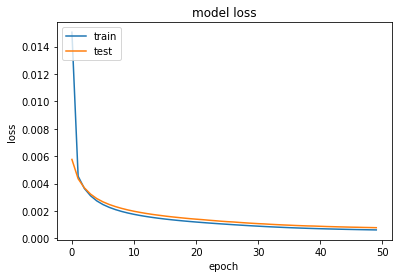

In [28]:
print (history_1.history.keys())

plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Output of encoding layer

In [29]:
encoded_imgs_1 = encoder_1.predict(clean_patches_train_8)
encoded_imgs_2 = encoder_1.predict(clean_patches_val_8)
print (encoded_imgs_1.shape)
print(encoded_imgs_2.shape)

(480000, 256)
(240000, 256)


## Autoencoder - 2

Model takes flattened 16x16 patches, encodes to size 32x32, and decodes to size 16x16

#### Dimensions

In [30]:
input_dim_2 = 16*16
encoding_dim_2 = 32*32
decoding_dim_2 = input_dim_2

#### Single fully connected layer

In [31]:
input_img_2 = Input(shape=(input_dim_2,))
encoded_2 = Dense(encoding_dim_2, activation='relu')(input_img_2)
decoded_2 = Dense(decoding_dim_2, activation='sigmoid')(encoded_2)

autoencoder_2 = Model(input_img_2, decoded_2)

#### Encoder model

In [32]:
encoder_2 = Model(input_img_2, encoded_2)

#### Configuring Autoencoder

In [33]:
autoencoder_2.compile(optimizer='adadelta', loss='mean_squared_error')

#### Dividing data into training and validation

In [34]:
# encoded_imgs_length = encoded_imgs_1.shape[0]
# one_third = int(encoded_imgs_length / 3)
# train_data_2 = encoded_imgs_1[:2*one_third]
# val_data_2 = encoded_imgs_1[2*one_third:]
# print(train_data_2.shape)
# print(val_data_2.shape)


#### Training Autoencoder

In [35]:
history_2 = autoencoder_2.fit(
    encoded_imgs_1, encoded_imgs_1,
    epochs = 50,
    batch_size = 256,
    shuffle = True,
    validation_data = (encoded_imgs_2, encoded_imgs_2))

Train on 480000 samples, validate on 240000 samples
Epoch 1/50
480000/480000 [==============================] - 73s 152us/step - loss: 0.1014 - val_loss: 0.0993
Epoch 2/50
480000/480000 [==============================] - 73s 152us/step - loss: 0.0969 - val_loss: 0.0983
Epoch 3/50
480000/480000 [==============================] - 71s 147us/step - loss: 0.0961 - val_loss: 0.0976
Epoch 4/50
480000/480000 [==============================] - 70s 146us/step - loss: 0.0955 - val_loss: 0.0972
Epoch 5/50
480000/480000 [==============================] - 71s 148us/step - loss: 0.0952 - val_loss: 0.0969
Epoch 6/50
480000/480000 [==============================] - 71s 147us/step - loss: 0.0949 - val_loss: 0.0966
Epoch 7/50
480000/480000 [==============================] - 70s 146us/step - loss: 0.0946 - val_loss: 0.0964
Epoch 8/50
480000/480000 [==============================] - 70s 146us/step - loss: 0.0945 - val_loss: 0.0962
Epoch 9/50
480000/480000 [==============================] - 70s 146us/step -

#### Plotting the loss

dict_keys(['val_loss', 'loss'])


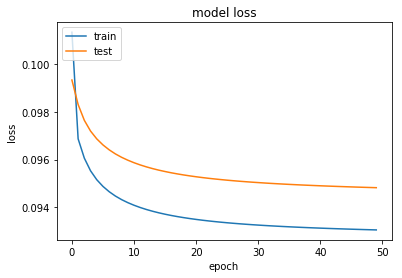

In [36]:
print (history_2.history.keys())

plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Less testing (validation) loss could be because we have trained this encoder on the same Since previous encoder the training and testing data given

## Stacked Sparse Denoising Autoencoder

The SSDA model now will take patches of size 8x8 as input. The first encoding layer expands an 8x8 patch to 16x16. The second encoding layer expands a 16x16 patch to 32x32. We then introduce the two decoding layers, which decrease the image from 32x32 to 16x16 to 8x8. 

The purpose of this model is take a noisy 8x8 image as input and return a clean 8x8 image as output.
The weights of the two encoding layers will be initialized with the encoding layer weights that were saved from the corresponding single autoencoder models above.

#### Dimensions

In [37]:
input_dim = 8*8
encoding_dim1 = 16*16
encoding_dim2 = 32*32
decoding_dim1 = encoding_dim1
decoding_dim2 = input_dim

#### Stack of layers

In [38]:
input_img = Input(shape=(input_dim,))

encoded1 = Dense(encoding_dim1, activation='relu')(input_img)
encoded2 = Dense(encoding_dim2, activation='relu')(encoded1)

decoded1 = Dense(decoding_dim1, activation='sigmoid')(encoded2)
decoded2 = Dense(decoding_dim2, activation='sigmoid')(decoded1)

autoencoder = Model(input_img, decoded2)

#### Encoder model

In [39]:
encoder1 = Model(input_img, encoded1)

encoded_img1 = Input(shape=(encoding_dim1,))
encoded2_layer = autoencoder.layers[-3]
encoder2 = Model(encoded_img1, encoded2_layer(encoded_img1))

encoder1.set_weights(encoder_1.get_weights())
encoder2.set_weights(encoder_2.get_weights())

#### Configuring Autoencoder

In [40]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

#### Training Autoencoder

In [41]:
history = autoencoder.fit(
    noisy_patches_train_8, clean_patches_train_8,
    epochs = 50,
    batch_size = 256,
    shuffle = True,
    validation_data = (noisy_patches_val_8, clean_patches_val_8))

Train on 480000 samples, validate on 240000 samples
Epoch 1/50
480000/480000 [==============================] - 75s 157us/step - loss: 0.0083 - val_loss: 0.0059
Epoch 2/50
480000/480000 [==============================] - 76s 158us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 3/50
480000/480000 [==============================] - 76s 159us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/50
480000/480000 [==============================] - 75s 157us/step - loss: 0.0039 - val_loss: 0.0040
Epoch 5/50
480000/480000 [==============================] - 76s 157us/step - loss: 0.0037 - val_loss: 0.0038
Epoch 6/50
480000/480000 [==============================] - 76s 158us/step - loss: 0.0035 - val_loss: 0.0037
Epoch 7/50
480000/480000 [==============================] - 76s 158us/step - loss: 0.0034 - val_loss: 0.0042
Epoch 8/50
480000/480000 [==============================] - 76s 158us/step - loss: 0.0033 - val_loss: 0.0035
Epoch 9/50
480000/480000 [==============================] - 76s 158us/step -

#### Plotting the loss

dict_keys(['val_loss', 'loss'])


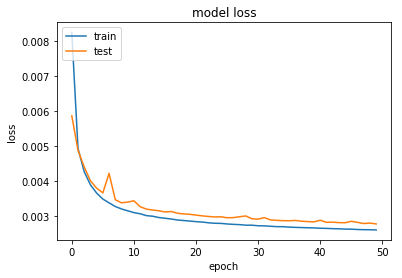

In [42]:
print (history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Saving weights

In [43]:
autoencoder.save_weights("SSDA_weights.h5")

### Testing Data

In [44]:
denoised_patches_test_8 = autoencoder.predict(noisy_patches_test_8)

### PSNR

In [45]:
import math

In [46]:
def calculate_mse(image1, image2):
    squared_error = (image1-image2)**2
    sum = np.sum(squared_error)
    mse = sum / float(squared_error.size)    
    return mse

In [47]:
MAX = 1 #We normalised the data
def calculate_psnr(image1, image2):
    return 20*math.log10(MAX) - 10*math.log10(calculate_mse(image1, image2))

In [48]:
def list_psnr(image_list_1, image_list_2):
    list_psnr= []
    for i in range(1000):
        psnr = calculate_psnr(image_list_1[i], image_list_2[i])
        list_psnr.append(psnr)
    return list_psnr

In [49]:
psnr_noisy_clean = list_psnr(noisy_patches_test_8, clean_patches_test_8)
psnr_denoised_clean = list_psnr(denoised_patches_test_8, clean_patches_test_8)

In [50]:
def plot_psnr(list1, list2):
    plt.plot(list1)
    plt.plot(list2)
    plt.title('PSNRs')
    plt.ylabel('psnr')
    plt.xlabel('patches')
    plt.legend(['noisy-clean', 'denoised-clean'], loc='upper left')
    plt.show()

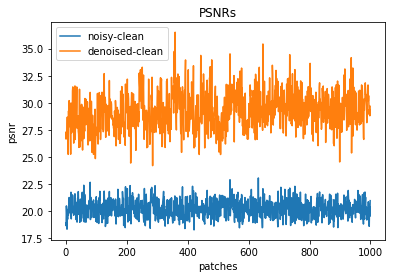

In [51]:
plot_psnr(psnr_noisy_clean, psnr_denoised_clean)